# Descobrindo dinâmicas não-lineares com SINDy Autoencoders

Neste notebook vamos tratar de aplicar SINDy Autoencoders para o mesmo problema físico dos outros exemplos, a saber: o pêndulo. Porém, desta vez trataremos da equação não-linear do pêndulo, i.e., $$\ddot{z} + \sin{(z)}=0,$$ onde esperamos que a natureza não linear da rede neural seja capaz de lidar com este sistema. 
* Algumas funções estão fora do Notebook para evitar que ficasse muito grande. Veja os arquivos `sindy_utils` onde temos algumas funções necesárias para calcular o tamanho da biblioteca de funções, `sindy_library` em que definimos tal biblioteca, baseado em quais funções queremos, e `datagenPendulum` onde geramos os dados de treino $$\{\mathbf{x}(t), \dot{\mathbf{x}}(t), \ddot{\mathbf{x}}(t)\},$$ veja que aqui usaremos somente a posição e a derivada. Note também que caso somente tenhamos os dados da posição no tempo, se a sequencia de imagens tiver um framerate suficientemente alto, sempre é possivel tomar a derivada numérica e calcular a imagem derivada e assim obter os outros dados. Então, na prática, é passível de tomarmos somente filmagens do pêndulo, sem saber sua velocidade ou aceleração. 
* Neste exemplo  não usamos CNNs, o que melhoraria a rede, porém para fins didáticos e científicos, queremos mostrar que a rede não depende de mais adições, o que sucintaria dúvidas sobre de onde advém a vantagem com relação obter modelos espaços de equações diferenciais.

### Declarando bibliotecas

* Caso não tenha uma GPU em mãos ou CUDA instalado, tome `device = "cpu"`

In [1]:
import os
import pandas as pd
import numpy as np
from datagenPendulum import get_pendulum_data
from sindy_utils import library_size
from sindy_library import SINDyLibrary
import torch as tc
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader, TensorDataset
import matplotlib.pyplot as plt

# Get cpu or gpu device for training.
device = "cuda" if tc.cuda.is_available() else "cpu"
print("Using {} device".format(device))

Using cuda device


## Buscando dados de treino

vamos treinar com as funções importadas de `datagenPendulum.py`

In [2]:
training_data = get_pendulum_data(100)
validation_data = get_pendulum_data(10)

### Vamos analisar como são os nossos dados, para isso plotamos cada  uma das entradas
* lembre que o nosso data-set é composto por $\{\mathbf{x}(t), \dot{\mathbf{x}}(t), \ddot{\mathbf{x}}(t)\},$ e também temos a inicialização aleatória das posições e velocidades iniciais $z,\dot{z}$, sempre respeitando a condição de energia para evitar voltas completas na oscilação do pêndulo $$ E = \dot{z}(0)/2 - \cos{z(0)} \leq 0.99$$

Text(0.5, 1.0, 'dz')

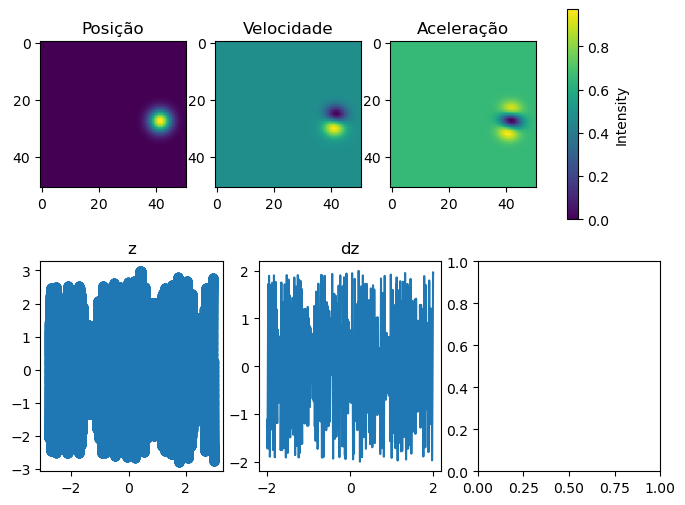

In [3]:
X, dX,ddX,z,dz = training_data['x'], training_data['dx'], training_data['ddx'], training_data['z'], training_data['dz']


fig, axs = plt.subplots(2, 3, figsize=(8, 6))  # 5 rows, 1 column

# Plot the first subplot
im1 = axs[0,0].imshow(X[0].reshape(51,51))
axs[0,0].set_title('Posição')
cbar1 = fig.colorbar(im1, ax=axs[0])
cbar1.set_label('Intensity')
im2 = axs[0,1].imshow(dX[0].reshape(51,51))
axs[0,1].set_title('Velocidade')
im3 = axs[0,2].imshow(ddX[0].reshape(51,51))
axs[0,2].set_title('Aceleração')
axs[1,0].scatter(np.linspace(min(z),max(z),len(z)),z)
axs[1,0].set_title('z')
axs[1,1].plot(np.linspace(min(dz),max(dz),len(dz)),dz)
axs[1,1].set_title('dz')




# Declarando parâmetros

Aqui declaramos alguns inputs que serão passados para o Modelo da rede em Pytorch.  Veja que há muitos outros parâmetros que poderiam ser repassados assim, para redes maiores. Manter os parâmetros como um dicionário separado da rede facilita a interpretação do código e o treinamento em que muitas variações serão testadas. 

In [4]:
params = {}

params['input_dim'] = training_data['x'].shape[-1]
params['latent_dim'] = 1
params['poly_order'] = 4
params['include_sine'] = True
params['learning_rate'] = 1e-4


## Declarando Rede

Diferentemente dos exemplos anteriores, em que declaramos tudo em uma rede só, aqui, para facilitar examinar o espaço latente $\mathbf{z}$ vamos declarar três modelos: Uma rede para o `Encoder()`, outra par ao `Decoder()`, e finalmente uma terceira que chama ambas as redes seccionalmente e aplica as condições para SINDy, aqui `Autoencoder()`, mas veja que as funções de declaração da biblioteca SINDy, parâmetros e máscara de coeficientes, são tomados como métodos.
* Veja como os parâmetros anteriores são aplicados aqui, colocando as funções como `True` as inclui na biblioteca:

``` python
    self.SINDyLibrary = SINDyLibrary(
                device=device,
                latent_dim=latent_dim, # definido nos parâmetros acima
                include_biases=False,
                include_states=True,
                include_sin=params['include_sine'], # definido nos parâmetros acima, aqui True
                include_cos=False,
                include_multiply_pairs=False, #caso para sistemas de mais dimensões como atratores de Lorentz, precisamos multiplicar os polinômios z_1z_2 etc
                poly_order=params['poly_order'], # definido nos parâmetros acima
                include_sqrt=False,
                include_inverse= False,
                include_sign_sqrt_of_diff=False)
            
            # Declaração como métodos dos coeficientes que multiplicam a biblioteca, $\Xi$. 
            self.XI = nn.Parameter(tc.full((self.SINDyLibrary.number_candidate_functions,latent_dim),1.,dtype = tc.float32,requires_grad=True,device = device))
            self.XI_coefficient_mask = tc.ones((self.SINDyLibrary.number_candidate_functions,latent_dim),dtype = tc.float32, device=device)
```

* Veja também que, agora, a rede é muito customizada, o que é uma tarefa razoavelmente direta graças à sintaxe do PyTorch e a declaração das redes por classes. O methodo que mais nos interessa aqui é o 

``` python
    def compute_quantities(self,x,xdot,xddot):
        # aplicação do encoder e decoder
        z = self.encoder(x)
        xtilde = self.decoder(z)

        # modelo vigente $z = \Theta \Xi = sindy_predict$
        theta = self.SINDyLibrary.transform(z) 
        scindy_predict = tc.matmul(theta, self.XI_coefficient_mask * self.XI)
        
        # lista de pesos para calcular propagação sobre encoder e $\nabla \varphi$
        encoder_parameters = list(self.encoder.parameters())
        encoder_weight_list = [w for w in encoder_parameters if len(w.shape) == 2]
        encoder_biases_list = [b for b in encoder_parameters if len(b.shape) == 1]

        # calculo das derivadas para z, d^2/dt^2 z
        zdot , zddot = self.z_derivative_order2(x, xdot, xddot, encoder_weight_list, encoder_biases_list)#, activation='relu')

        # lista de pesos para calcular a propagação sobre o decoder $\nabla \psi$
        decoder_parameters = list(self.decoder.parameters())
        decoder_weight_list = [w for w in decoder_parameters if len(w.shape) == 2]
        decoder_biases_list = [b for b in decoder_parameters if len(b.shape) == 1]

        # calcula derivadas para d^2/dt^2 x
        xtildedot , xtildeddot = self.z_derivative_order2(z, zdot, scindy_predict, decoder_weight_list, decoder_biases_list, activation='relu')    
        
        return xtilde, xtildedot, xtildeddot, z, zdot, zddot, scindy_predict
```

* REF: Uma aplicação muito similar somente para a primeira derivada pode ser encontrada em [este post](https://pietro-sillano.github.io/projects/2.SINDY/)

In [5]:
class Encoder(nn.Module):
    def __init__(self, input_size, latent_dim):
        super(Encoder, self).__init__()
        self.fc0 = nn.Linear(input_size,256)
        self.fc1 = nn.Linear(256,128)
        self.fc33 = nn.Dropout(0.5)
        self.fc2 = nn.Linear(128,64)
        self.fc3 = nn.Linear(64,32)
        self.fc4 = nn.Linear(32,latent_dim)
        self.initialize_weights()

    def initialize_weights(self):
        for m in self.modules():
            print(m)
            if isinstance(m, nn.Linear):
                nn.init.kaiming_normal_(m.weight, a=0, mode='fan_in', nonlinearity='relu')
                if m.bias is not None:
                    nn.init.constant_(m.bias, 0.1)

    def forward(self, x):
        x = tc.relu(self.fc0(x))
        x = tc.relu(self.fc1(x))
        x = tc.relu(self.fc2(x))
        x = tc.relu(self.fc33(x))
        x = tc.relu(self.fc3(x))   
        x = tc.relu(self.fc4(x))
        return x 

class Decoder(nn.Module):
    def __init__(self, input_size,latent_dim):
        super(Decoder, self).__init__()
        self.fc1 = nn.Linear(latent_dim,32)
        self.fc2 = nn.Linear(32,64)
        self.fc3 = nn.Linear(64,128)
        self.fc33 = nn.Dropout(0.5)
        self.fc4 = nn.Linear(128,256)
        self.fc5 = nn.Linear(256,input_size)
        self.initialize_weights()

    def forward(self, x):
        x = tc.relu(self.fc1(x))
        x = tc.relu(self.fc2(x))
        x = tc.relu(self.fc33(x))   
        x = tc.relu(self.fc3(x))
        x = tc.relu(self.fc4(x))
        x = tc.sigmoid(self.fc5(x))
        return x

    def initialize_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Linear):
                nn.init.kaiming_normal_(m.weight, a=0, mode='fan_in', nonlinearity='relu')
                if m.bias is not None:
                    nn.init.constant_(m.bias, 0.1)

class Autoencoder(nn.Module):
    def __init__(self, params):
        super(Autoencoder, self).__init__()
        # importing parameters 
        input_size = params['input_dim']
        latent_dim = params['latent_dim']
        if 'include_sine' in params.keys():
            include_sine = params['include_sine']
        else:
            include_sine = False
        
        # defining network bits
        self.encoder = Encoder(input_size,latent_dim)
        self.decoder = Decoder(input_size,latent_dim)
        self.SINDyLibrary = SINDyLibrary(
            device=device,
            latent_dim=latent_dim,
            include_biases=False,
            include_states=True,
            include_sin=params['include_sine'],
            include_cos=False,
            include_multiply_pairs=False, # usado somente para sistemas de mais dimensões, como atratores de Lorentz, ou reação-difusão
            poly_order=params['poly_order'],
            include_sqrt=False,
            include_inverse= False,
            include_sign_sqrt_of_diff=False)
        
        # Declaração como métodos dos coeficientes que multiplicam a biblioteca, $\Xi$. 
        self.XI = nn.Parameter(tc.full((self.SINDyLibrary.number_candidate_functions,latent_dim),1.,dtype = tc.float32,requires_grad=True,device = device))
        self.XI_coefficient_mask = tc.ones((self.SINDyLibrary.number_candidate_functions,latent_dim),dtype = tc.float32, device=device)


    def configure_optimizers(self):
        learning_rate = params['learning_rate']
        return tc.optim.Adam(self.parameters(), lr=learning_rate)

    def z_derivative_order2(self, input, dx, ddx, weights, biases, activation='relu'):
        """
        Compute the first and second order time derivatives by propagating through the network.

        Arguments:
            input - 2D PyTorch tensor, input to the network. Dimensions are number of time points
            by number of state variables.
            dx - First order time derivatives of the input to the network.
            ddx - Second order time derivatives of the input to the network.
            weights - List of PyTorch tensors containing the network weights
            biases - List of PyTorch tensors containing the network biases
            activation - String specifying which activation function to use. Options are
            'elu', 'relu', 'sigmoid', or 'linear'.

        Returns:
            dz - PyTorch tensor, first order time derivatives of the network output.
            ddz - PyTorch tensor, second order time derivatives of the network output.
        """
        dz = dx
        ddz = ddx

        for i in range(len(weights)-1):
            input = tc.matmul(input, weights[i].T) + biases[i]
            dz_prev = tc.matmul(dz, weights[i].T)

            if activation == 'elu':
                elu_derivative = tc.where(input < 0, tc.exp(input), tc.tensor(1.0))
                elu_derivative2 = tc.exp(input) * (input < 0).float()
                dz = elu_derivative * dz_prev
                ddz = elu_derivative2 * dz_prev.pow(2) + elu_derivative * tc.matmul(ddz, weights[i].T)
                input = F.elu(input)

            elif activation == 'relu':
                relu_derivative = (input > 0).float()
                dz = relu_derivative * tc.matmul(dz, weights[i].T)
                ddz = relu_derivative * tc.matmul(ddz, weights[i].T)
                input = F.relu(input)

            elif activation == 'sigmoid':
                sigmoid = tc.sigmoid(input)
                sigmoid_derivative = sigmoid * (1 - sigmoid)
                sigmoid_derivative2 = sigmoid_derivative * (1 - 2 * sigmoid)
                dz = sigmoid_derivative * dz_prev
                ddz = sigmoid_derivative2 * dz_prev.pow(2) + sigmoid_derivative * tc.matmul(ddz, weights[i].T)

            else:  # Linear activation
                dz = tc.matmul(dz, weights[i].T)
                ddz = tc.matmul(ddz, weights[i].T)

        # Final layer without activation
        dz = tc.matmul(dz, weights[-1].T) + biases[-1]
        ddz = tc.matmul(ddz, weights[-1].T) + biases[-1]

        return dz, ddz
    
    def compute_quantities(self,x,xdot,xddot):
        # aplicação do encoder e decoder
        z = self.encoder(x)
        xtilde = self.decoder(z)

        # modelo vigente $z = \Theta \Xi = sindy_predict$
        theta = self.SINDyLibrary.transform(z) 
        scindy_predict = tc.matmul(theta, self.XI_coefficient_mask * self.XI)
        
        # lista de pesos para calcular propagação sobre encoder e $\nabla \varphi$
        encoder_parameters = list(self.encoder.parameters())
        encoder_weight_list = [w for w in encoder_parameters if len(w.shape) == 2]
        encoder_biases_list = [b for b in encoder_parameters if len(b.shape) == 1]

        # calculo das derivadas para z, d^2/dt^2 z
        zdot , zddot = self.z_derivative_order2(x, xdot, xddot, encoder_weight_list, encoder_biases_list)#, activation='relu')

        # lista de pesos para calcular a propagação sobre o decoder $\nabla \psi$
        decoder_parameters = list(self.decoder.parameters())
        decoder_weight_list = [w for w in decoder_parameters if len(w.shape) == 2]
        decoder_biases_list = [b for b in decoder_parameters if len(b.shape) == 1]

        # calcula derivadas para d^2/dt^2 x
        xtildedot , xtildeddot = self.z_derivative_order2(z, zdot, scindy_predict, decoder_weight_list, decoder_biases_list, activation='relu')    
        
        return xtilde, xtildedot, xtildeddot, z, zdot, zddot, scindy_predict

    def loss_function(self, x, xdot, xddot, xtilde, xtildedot, xtildeddot, zdot, zddot, scindy_predict,XI):
        '''toma entradas e saidas e devolve todas as loss functions em um dicionário '''
        mse = nn.MSELoss()
        # estes valores são usados na soma das loss functions, poderiam ser parâmetros externos
        alpha1 = 5e-4 
        alpha2 = 5e-5
        alpha3 = 1e-5

        # declaração das loss functions
        loss = {}
        loss['recon_loss'] = mse(x, xtilde) # Loss de reconstrução da imagem da posição
        #loss ['sindy_loss_x'] = mse(xdot, xtildedot) # Loss para dinamicas com derivadas de de ordem 1 (não é usado aqui) 
        loss ['sindy_loss_z'] = mse(zddot, scindy_predict) # Loss da derivada em z, dz/dt 
        loss ['sindy_loss_ddx'] = mse(xddot,xtildeddot) # loss da derivada em $\tilde{\ddot{x}}$,i.e., da imagem da aceleração com a aceleração do modelo
        loss['sindy_regular_loss'] = tc.sum(tc.abs(XI)) #norma L1 dos coeficientes XI

        loss['tot'] = loss['recon_loss'] + alpha1*loss['sindy_loss_ddx'] + alpha2*loss['sindy_loss_z'] + alpha3*loss['sindy_regular_loss']
        
        # tentativa de incluir a primeira derivada também, a performance é melhor
        #loss['tot'] = loss['recon_loss'] + alpha1*(loss['sindy_loss_ddx'] + loss['sindy_loss_x']) + alpha2*loss['sindy_loss_z'] + alpha3*loss['sindy_regular_loss']
        
        tot = loss['tot']
        return tot, loss
    
    
    def forward(self, x, xdot, xddot):
        return self.compute_quantities(x, xdot, xddot)

#### Inicializando e salvando o modelo na memória

In [6]:

model = Autoencoder(params).to(device)

Encoder(
  (fc0): Linear(in_features=2601, out_features=256, bias=True)
  (fc1): Linear(in_features=256, out_features=128, bias=True)
  (fc33): Dropout(p=0.5, inplace=False)
  (fc2): Linear(in_features=128, out_features=64, bias=True)
  (fc3): Linear(in_features=64, out_features=32, bias=True)
  (fc4): Linear(in_features=32, out_features=1, bias=True)
)
Linear(in_features=2601, out_features=256, bias=True)
Linear(in_features=256, out_features=128, bias=True)
Dropout(p=0.5, inplace=False)
Linear(in_features=128, out_features=64, bias=True)
Linear(in_features=64, out_features=32, bias=True)
Linear(in_features=32, out_features=1, bias=True)


#### Verificando quais funções estão na biblioteca e serão usadas no modelo
i.e., estamos basicamente printando $\Theta$

In [7]:
model.SINDyLibrary.feature_names


['z0', 'sin(z0)', 'z0*z0', 'z0*z0*z0', 'z0*z0*z0*z0']

## Examinando os dados de treinamento
* Nossos dados são imagens, mas como não vamos usar CNN, eles estarão declarados como um vetor, i.e., usamos o método .flatten() do numpy para "achatar" a matriz da imagem (tamanho 51x51) em um vetor (tamanho 1x2601)

In [8]:
X[1]

array([1.59920870e-78, 5.80664787e-76, 1.82560758e-73, ...,
       1.57577232e-17, 5.69731662e-18, 1.78364671e-18])

* Convertendo os arrays de numpy para tensores de Pytorch

In [9]:
X = tc.from_numpy(X).float().to(device)
dX = tc.from_numpy(dX).float().to(device)
ddX = tc.from_numpy(ddX).float().to(device)
z = tc.from_numpy(z).float().to(device)
dz = tc.from_numpy(dz).float().to(device)


X.shape, dX.shape, X.dtype

(torch.Size([50000, 2601]), torch.Size([50000, 2601]), torch.float32)

In [10]:
X[1], dX[1], ddX[1], z[1], dz[1]

(tensor([0.0000e+00, 0.0000e+00, 0.0000e+00,  ..., 1.5758e-17, 5.6973e-18,
         1.7836e-18], device='cuda:0'),
 tensor([-0.0000e+00, -0.0000e+00, -0.0000e+00,  ..., 8.9307e-16, 3.2032e-16,
         9.9476e-17], device='cuda:0'),
 tensor([0.0000e+00, 0.0000e+00, 0.0000e+00,  ..., 5.0087e-14, 1.7799e-14,
         5.4760e-15], device='cuda:0'),
 tensor([1.4039], device='cuda:0'),
 tensor([-1.1335], device='cuda:0'))

## Escolhendo dados de validação, mesmo procedimento

In [11]:
X_val = tc.from_numpy(validation_data['x']).float().to(device)
dX_val = tc.from_numpy(validation_data['dx']).float().to(device)
ddX_val = tc.from_numpy(validation_data['ddx']).float().to(device)
z_val = tc.from_numpy(validation_data['z']).float().to(device)
dz_val = tc.from_numpy(validation_data['dz']).float().to(device)


In [12]:
train_size, val_size = X.shape[0], X_val.shape[0]
batch_size =  320
dataset = TensorDataset(X,dX,ddX)
validation_set = TensorDataset(X_val,dX_val,ddX_val)

train_loader = DataLoader(dataset, shuffle=True, batch_size=batch_size)
val_loader   = DataLoader(validation_set, shuffle=False, batch_size=batch_size)

# Treinamento

* Aqui vamos declarar algumas funções para que possamos ter prints mais intuitivos, além de também salvar nosso modelo encontrado e a loss function a cada numero de epochs
* também nessa célula declaramos o corte de coeficientes $\xi$ que estão abaixo do nosso threshold $0.1$, na função `sequencial_threshold()`

In [13]:
def save_model(path, t,saving_rate,exp):
    
    '''saves model into a .npy file'''
    
    if SAVE == True:
        if t % saving_rate == 0 and t > 0:
            print('saved in ',t,"epoche")
            f1 = path + 'model'+str(exp) + '_' + str(t) + 'epochs' + '.pt'
            tc.save({
            'epoch': t,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': model.configure_optimizers().state_dict(),
            'loss': model.loss_function,
            'sindy_coefficients': model.XI,
            'coefficient_mask' : model.XI_coefficient_mask
            }, f1)
            
            XI = model.XI.cpu().detach().numpy()
            np.save(path + 'model'+str(exp) + '_' + str(t) + 'epochs' + '.npy',XI)

def print_model(t,exp):
    
    ''' prints model into a .txt file'''

    f = open(path + 'model'+str(exp)+'_equation' + '_' + str(t) + '.txt', 'w')
    coefficient_mask = model.XI_coefficient_mask.cpu().detach().numpy()
    XI = model.XI.cpu().detach().numpy()
    feature_list = model.SINDyLibrary.get_feature_names()
    latent_dim = params['latent_dim']
    for j in range(latent_dim):
        k=0
        for i in range(len(feature_list)-1):
            coeff = XI[i][j] * coefficient_mask[i][j]      
            if  abs(coeff) >= 0.1 and coeff != 0:
                if k<1:
                    f.write(f"ddz{j} = {coeff:.6f} {feature_list[i]}")
                else:
                    f.write(f"+ {coeff:.6f} {feature_list[i]}")
                k+=1
    f.close()

def sequential_threshold(epoch, seq_thres):

    ''' decides when to delete small coefficientes in XI'''
    
    if (epoch % seq_thres == 0 and epoch>1):
        print('Sequencial threshold, deleting coefficients below 0.1..')
        model.XI_coefficient_mask = tc.abs(model.XI) > 0.1


#training step for one epoch
def train_step(loss_list):

    ''' does one training epoch'''    

    loss_epoch = {}
    loss_epoch['recon_loss'] = []
    #loss_epoch['sindy_loss_x'] = []
    loss_epoch['sindy_loss_ddx'] = []
    loss_epoch['sindy_loss_z'] = []
    loss_epoch['sindy_regular_loss'] = []
    loss_epoch['tot'] = []
    
    model.train()
    for batch, (X,Xdot,Xddot) in enumerate (train_loader):
        X.to(device) # para passar para a gpu
        Xdot.to(device)
        Xddot.to(device)
        
        #forward pass 
        xtilde, xtildedot, xtildeddot, z, zdot, zddot, scindy_predict = model(X,Xdot, Xddot)

        # Backpropagation
        optimizer = model.configure_optimizers()

        # calcula valores da loss
        loss, loss_dict = model.loss_function(X, Xdot,Xddot, xtilde, xtildedot,xtildeddot, zdot,zddot, scindy_predict,model.XI)
        loss.backward()
        
        optimizer.step()
        optimizer.zero_grad()

        # salva loss encontradas no dicionario
        for key in loss_epoch.keys():
            loss_epoch[key].append(loss_dict[key].item())
        
        
    for key in loss_epoch.keys():
            loss_list[key].append(sum(loss_epoch[key])/len(loss_epoch[key]))

    # deleta variáveis para liberar memória            
    del loss_epoch,loss_dict,xtilde, xtildedot,xtildeddot, z, zdot, zddot, scindy_predict,loss


def validation_step(loss_val_list):

    ''' calculates loss for validation data'''
    
    loss_val_epoch = []
    model.eval()     # Optional when not using Model Specific layer
    for batch, (X,Xdot, Xddot) in enumerate (val_loader):
        X.to(device) 
        Xdot.to(device)
        Xddot.to(device)

        #forward pass 
        xtilde, xtildedot, xtildeddot, z, zdot, zddot,scindy_predict = model(X,Xdot, Xddot)
        
        # validation loss 
        loss, _ = model.loss_function(X, Xdot,Xddot, xtilde, xtildedot,xtildeddot, zdot,zddot, scindy_predict,model.XI)
        loss_val_epoch.append(loss.item())

        del  xtilde, xtildedot, xtildeddot, z, zdot, zddot, scindy_predict,loss

    loss_val_list.append(sum(loss_val_epoch)/len(loss_val_epoch))

def print_loss(t,loss_rate, loss_list):
    ''' simple prints of the Epochs to keep track of training'''
    if t % loss_rate == 0:
        print()
        print(f"Epoch {t}\n-------------------------------")
        for key in loss_list.keys():
            temp = loss_list[key]
            print(f'{key} of epoch {t}: {temp[-1]:.3e}')

In [14]:
import numpy as np
import matplotlib.pyplot as plt

def plot_validation_comparison(epoch, val_rate, experiment):
    """
    Plots a Matplotlib figure comparing x, xdot, xddot to the predicted xtilde, xtildedot, xtildeddot 
    in the validation dataset. Also states the current found model.
    
    Parameters:
        epoch (int): Current training epoch.
        val_rate (int): Validation interval.
        experiment (str): Experiment identifier for labeling.
    """
    # Time steps to evaluate
    time_steps = range(0, 2001, 600)

    for time in time_steps:
        if epoch % val_rate == 0 and epoch > 1:
            X_p, dX_p, ddX_p = validation_data['x'], validation_data['dx'], validation_data['ddx']

            X_pred, dX_pred, ddX_pred, _, _, _, scindy_predict = model(X_val, dX_val, ddX_val)
            X_pred = X_pred.cpu().detach().numpy()
            dX_pred = dX_pred.cpu().detach().numpy()
            ddX_pred = ddX_pred.cpu().detach().numpy()

            print('\n Model is now:')
            coefficient_mask = model.XI_coefficient_mask.cpu().detach().numpy()
            XI = model.XI.cpu().detach().numpy()
            feature_list = model.SINDyLibrary.get_feature_names()
            latent_dim = params['latent_dim']

            for j in range(latent_dim):
                k = 0
                for i in range(len(feature_list) - 1):
                    coeff = XI[i][j] * coefficient_mask[i][j]      
                    if abs(coeff) >= 0.1 and coeff != 0:
                        if k < 1:
                            print(f"ddz{j} = {coeff:.6f} {feature_list[i]}")
                        else:
                            print(f"+ {coeff:.6f} {feature_list[i]}")
                        k += 1

            # Create figure and subplots
            fig, axs = plt.subplots(2, 3, figsize=(10, 7))

            # Plot images
            images = []
            images.append(axs[0,0].imshow(X_p[time].reshape(51,51), cmap='viridis'))
            images.append(axs[0,1].imshow(dX_p[time].reshape(51,51), cmap='viridis'))
            images.append(axs[0,2].imshow(ddX_p[time].reshape(51,51), cmap='viridis'))
            images.append(axs[1,0].imshow(X_pred[time].reshape(51,51), cmap='viridis'))
            images.append(axs[1,1].imshow(dX_pred[time].reshape(51,51), cmap='viridis'))
            images.append(axs[1,2].imshow(ddX_pred[time].reshape(51,51), cmap='viridis'))

            # Titles
            axs[0,0].set_title('Posição Original')
            axs[0,1].set_title('Velocidade Original')
            axs[0,2].set_title('Aceleração Original')
            axs[1,0].set_title('Posição Prevista')
            axs[1,1].set_title('Velocidade Prevista')
            axs[1,2].set_title('Aceleração Prevista')

            # Remove axis labels for better visualization
            for ax in axs.flatten():
                ax.set_xticks([])
                ax.set_yticks([])

            # Adjust layout to make space for colorbar
            plt.subplots_adjust(right=0.85)  # Shrinks the plot area

            # Create colorbar axis and add colorbar
            cbar_ax = fig.add_axes([0.88, 0.2, 0.02, 0.6])  # [left, bottom, width, height]
            cbar = fig.colorbar(images[-1], cax=cbar_ax)  # Use the last image as reference
            cbar.set_label(f'Intensidade experimento {experiment}')

            plt.show()


### Declarando parâmetros de treino para as funções acima

In [15]:
VALIDATION = True
SAVE = False 

epochs = 2001
#path = '../model/'

path = './saved_models/'
seq_thres = 251   # Numero de epochs apos o qual aplicamos o threshold sequencial

equation_rate = 500 # print das equações encontradas em um arquivo .txt

saving_rate = epochs//2 # numero de epochs em que salva o modelo (os parametros da rede)

loss_rate = 250  # print no terminal dos valores das loss até entao

# print dos plots comparando x,xdot,xddot, e os encontrados xtilde,xtildedot xtildeddot no validation data-set 
# Também printa o modelo sindy encontrado
val_print_rate = 500 


In [16]:
loss_list = {}
loss_list['recon_loss'] = []
#loss_list['sindy_loss_x'] =[]
loss_list['sindy_loss_ddx'] = []
loss_list['sindy_loss_z'] = []
loss_list['sindy_regular_loss'] = []
loss_list['tot'] = []
loss_val_list = []

# aqui declaramos vários "experimentos" pois nem sempre a rede converge para o modelo certo
for experiment in range(0,3):
    
    loss_list = {}
    loss_list['recon_loss'] = []
    #loss_list['sindy_loss_x'] =[]
    loss_list['sindy_loss_ddx'] = []
    loss_list['sindy_loss_z'] = []
    loss_list['sindy_regular_loss'] = []
    loss_list['tot'] = []
    loss_val_list = []

    epoch =1
    model = Autoencoder(params).to(device)
    print('-'*50)
    print(f'Experiment number {experiment}')
    while epoch <= epochs:
        
        if epoch % 400 ==0:
            print(f"epoch: [{epoch}/ {epochs}]")
        #print(f"epoch: [{epoch}/ {epochs}]")
        
        train_step(loss_list)
        
        validation_step(loss_val_list)
        
        print_loss(epoch, loss_rate, loss_list)

        save_model(path, epoch, saving_rate,experiment)
        
        sequential_threshold(epoch,seq_thres)

        plot_validation_comparison(epoch, val_print_rate, experiment)
        
        if epoch % equation_rate == 0 and epoch>1:
            print_model(epoch,experiment)
            data = pd.DataFrame.from_dict(loss_list)
            data.to_csv(path + 'data'+str(experiment)+'_'+str(epoch)+'epochs'+'.csv')
            tc.save(model.state_dict(), path + 'NetworkParameters'+str(experiment)+'_'+str(epoch)+'epochs'+'.pth')  # Saves only the state_dict

        epoch = epoch + 1
    print("Done!")

## Avaliação dos resultados

* Aqui vamos printar algumas imagens do nosso conjunto de validação e verificar a qualidade do output com relação a imagens que a rede nunca viu durante o treinamento


 Model is now:
ddz0 = 1.344340 sin(z0)


/tmp/ipykernel_3866122/55422024.py:82: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


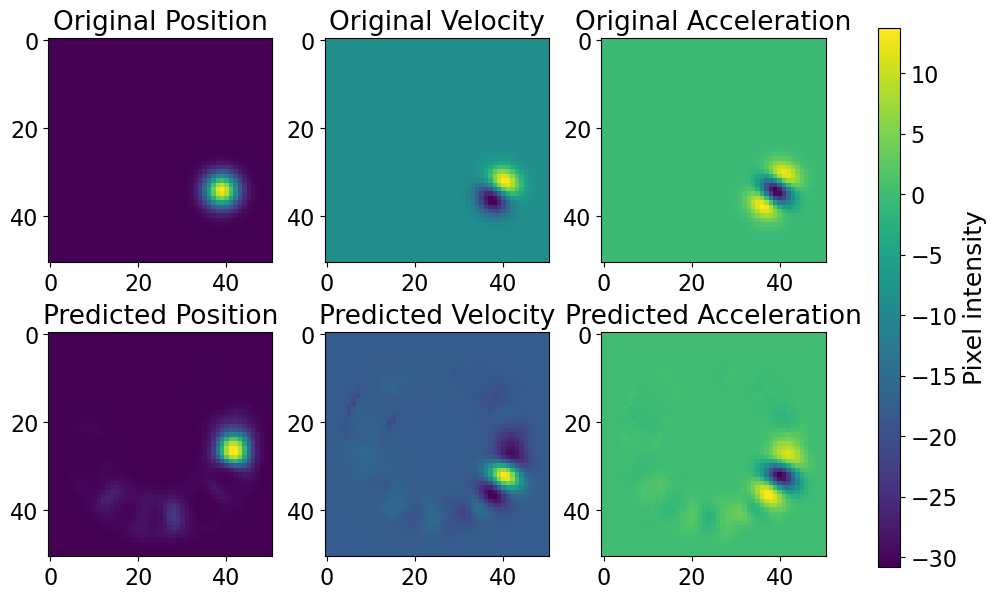

In [81]:

# Load loss function data
#path = "./saved_models/data2_1000epochs.csv"
#loss_data = pd.read_csv(path)

# Assuming your model is a PyTorch-based neural network, load the trained model
# If you have a .pth file instead, use: model.load_state_dict(torch.load('model.pth'))
# model = YourModelClass()  # Define the model architecture
model.load_state_dict(tc.load("/home/user/Documents/Gustavo_Cafe/Notebooks_ML/Notebooks_NN_Physics/SINDyAutoencoder/saved_models/Working3_NetworkParameters2_2000epochs.pth"))
model.eval()

import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

X_p, dX_p, ddX_p = validation_data['x'], validation_data['dx'], validation_data['ddx']

for time in range(1650, 2001, 1400):

    X_pred, dX_pred, ddX_pred, _, _, _, scindy_predict = model(X_val, dX_val, ddX_val)
    X_pred = X_pred.cpu().detach().numpy()
    dX_pred = dX_pred.cpu().detach().numpy()
    ddX_pred = ddX_pred.cpu().detach().numpy()

    print('\n Model is now:')
    coefficient_mask = model.XI_coefficient_mask.cpu().detach().numpy()
    XI = model.XI.cpu().detach().numpy()
    feature_list = model.SINDyLibrary.get_feature_names()
    latent_dim = params['latent_dim']

    for j in range(latent_dim):
        k = 0
        for i in range(len(feature_list)-1):
            coeff = XI[i][j] * coefficient_mask[i][j]      
            if abs(coeff) >= 0.1 and coeff != 0:
                if k < 1:
                    print(f"ddz{j} = {coeff:.6f} {feature_list[i]}")
                else:
                    print(f"+ {coeff:.6f} {feature_list[i]}")
                k += 1

    # Create figure and layout
    fig = plt.figure(figsize=(11, 7))
    gs = gridspec.GridSpec(2, 4, width_ratios=[1, 1, 1, 0.1], wspace=0.3)
    axs = [[fig.add_subplot(gs[i, j]) for j in range(3)] for i in range(2)]

    # Tick settings
    tick_positions = [0, 20, 40]
    tick_fontsize = 16
    title_fontsize = 19

    # Plotting
    images = [
        axs[0][0].imshow(X_p[time].reshape(51, 51), cmap='viridis'),
        axs[0][1].imshow(dX_p[time].reshape(51, 51), cmap='viridis'),
        axs[0][2].imshow(ddX_p[time].reshape(51, 51), cmap='viridis'),
        axs[1][0].imshow(X_pred[time].reshape(51, 51), cmap='viridis'),
        axs[1][1].imshow(dX_pred[time].reshape(51, 51), cmap='viridis'),
        axs[1][2].imshow(ddX_pred[time].reshape(51, 51), cmap='viridis')
    ]

    titles = [
        'Posição Original', 'Velocidade Original', 'Aceleração Original',
        'Posição Prevista', 'Velocidade Prevista', 'Aceleração Prevista'
    ]

    titles = ['Original Position', 'Original Velocity', 'Original Acceleration',
              'Predicted Position', 'Predicted Velocity', 'Predicted Acceleration'
    ]

    for i in range(2):
        for j in range(3):
            axs[i][j].set_title(titles[i*3 + j], fontsize=title_fontsize)
            axs[i][j].set_xticks(tick_positions)
            axs[i][j].set_yticks(tick_positions)
            axs[i][j].tick_params(labelsize=tick_fontsize)

    # Add colorbar
    cax = fig.add_subplot(gs[:, 3])
    cbar = fig.colorbar(images[-1], cax=cax)
    cbar.set_label('Pixel intensity', fontsize=18)
    cbar.ax.tick_params(labelsize=tick_fontsize)

    plt.tight_layout()
    plt.show()


# Avaliação da função loss
* Veja que temos muitos termos na nossa loss function.
\begin{equation}
    \mathcal{L}_{\text{SINDy}} = \mathcal{L}_{\text{recon}} + \lambda_1\mathcal{L}_{\dot{x}} + \lambda_2\mathcal{L}_{\dot{z}} + \lambda_3||\boldsymbol{\Xi}||_1
\end{equation}

Onde 
\begin{equation}
    \mathcal{L}_{\text{recon}} = || \mathbf{x} - \psi \circ \varphi (\mathbf{x})||^2_2,
\end{equation}

A reconstrução da segunda derivada da imagem em termos de $z$

\begin{equation}
    \mathcal{L}_{\dot{\mathbf{x}}} = ||\ddot{\mathbf{x}} - \nabla_z^2 \psi (z) \dot{z} + \nabla_z \psi(z) \boldsymbol{\Theta}(z) \boldsymbol{\Xi} ||^2_2,
\end{equation}

\begin{equation}
   \quad \qquad \qquad = ||\ddot{\mathbf{x}} - \nabla_z^2 \psi (z) \nabla_x \varphi(\mathbf{x})\dot{\mathbf{x}} + \nabla_z \psi(z) \boldsymbol{\Theta}(z) \boldsymbol{\Xi} ||^2_2,
\end{equation}

E finalmente o termo relativo a segunda derivada do modelo gerado para $z$

\begin{equation}
    \mathcal{L}_{\dot{z}} =  || \nabla_x^2 \varphi (\mathbf{x}) \dot{\mathbf{x}}^2 + \nabla_x \varphi (\mathbf{x}) \ddot{\mathbf{x}} -  \boldsymbol{\Theta}(z(t))\boldsymbol{\Xi} ||^2_2.
\end{equation}

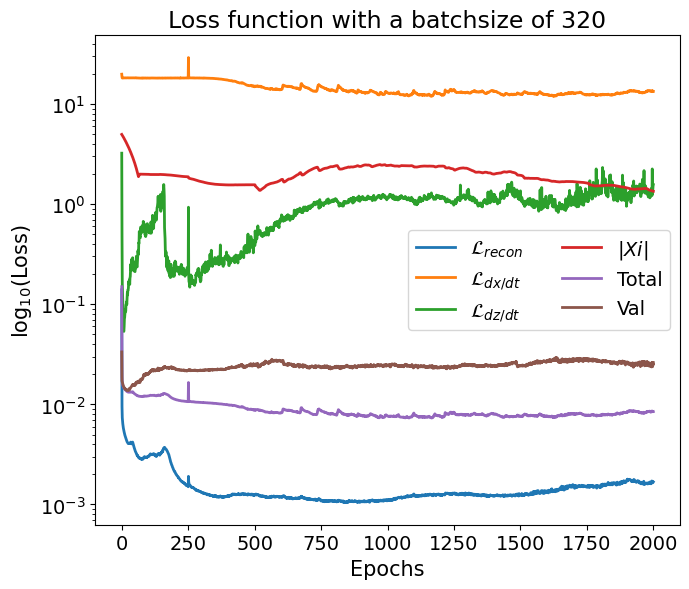

In [80]:
def plot_losses(loss_list, epoch):
    import pandas as pd
    import matplotlib.pyplot as plt

    labels = ["$\mathcal{L}_{recon}$", "$\mathcal{L}_{dx/dt}$", "$\mathcal{L}_{dz/dt}$", "$|Xi|$", "Total", "Val"]
    data = pd.DataFrame.from_dict(loss_list)
    data.to_csv(f'./data_{epoch}epochs.csv')

    fig, ax = plt.subplots(figsize=(7,6))

    # Plot training losses
    for i, key in enumerate(loss_list.keys()):
        ax.semilogy(loss_list[key], label=labels[i], linewidth=2)

    # Plot validation loss if exists
    if 'loss_val_list' in globals():
        ax.semilogy(loss_val_list, label=labels[-1], linewidth=2)

    # Formatting
    # After plotting everything
    ymin, ymax = ax.get_ylim()
    ax.set_ylim(ymin, ymax )  # Make space above the highest curve

    ax.set_title(f'Loss function with a batchsize of {batch_size}', fontsize=17)
    ax.set_xlabel('Epochs', fontsize=15)
    ax.set_ylabel(r'$\log_{10}(\mathrm{Loss})$', fontsize=15)

    ax.tick_params(axis='both', which='major', labelsize=14)

    # Legend outside the plot
    ax.legend(loc='center right',# bbox_to_anchor=(0.5, -0.15), 
              ncol=2, fontsize=14, frameon=True)

    plt.tight_layout()
    plt.show()


plot_losses(loss_list, epochs)